# TRY-Analysis

The Titer, pRoductivity, and Yield (TRY) are main technological parameters in fermentation that impact the economic feasibility of a bioprocess, making them key targets for improvements. BioSTEAM presents tools for analyzing and visualizing how changes in TRY parameters can impact key metrics. The following example demonstrates how to use these tools.

## Setup up the biorefinery model

Before we can perform any analysis, we first create the model that will be used to perform the analysis. As a simple example, we model the fermentation and downstream separtation of a conventional sugarcane ethanol plant:

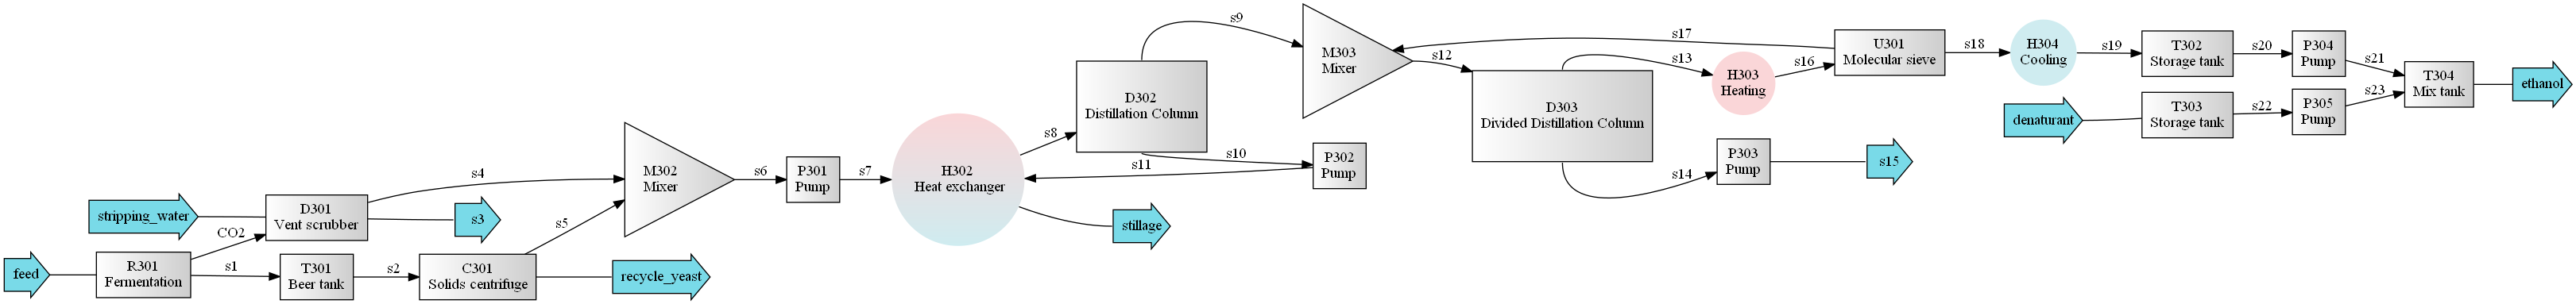

In [1]:
import numpy as np
import biosteam as bst
from biosteam import units, main_flowsheet as F
from biorefineries import sugarcane as sc
bst.settings.set_thermo(sc.chemicals)

# Ethanol Production
feed = bst.Stream('feed',
           Glucose=3.8e+03,
           Sucrose=4.31e+04,
           Water=1.03e+05,
           DryYeast=1.03e+04,
           H3PO4=83.3,
           units='kg/hr',
           T=295.98)
R301 = units.Fermentation('R301', feed, ('CO2', ''), tau=9, efficiency=0.90, N=4)
R301.cell_growth_reaction.X = 0. # Ignore for simplicity
T301 = units.StorageTank('T301', tau=4, vessel_material='Carbon steel')
T301.line = 'Beer tank'

stripping_water = bst.Stream('stripping_water', Water=5000, units='kg/hr')
D301 = units.VentScrubber('D301', ins=(stripping_water, R301-0), gas=('CO2',))

# Separate 99% of yeast
C301 = units.SolidsCentrifuge('C301', outs=('', 'recycle_yeast'),
                            split=(1, 0.99999, 1, 0.01),
                            order=('Ethanol', 'Glucose', 'H3PO4', 'DryYeast'),
                            solids=('DryYeast',))

# Mix in Water
M302 = units.Mixer('M302')
P301 = units.Pump('P301')

# Heat up before beer column
# Exchange heat with stillage
H302 = units.HXprocess('H302', outs=('', 'stillage'),
                      phase0='l', phase1='l', U=1.28)

# Beer column
xbot = 5e-06
ytop = 0.345
D302 = units.BinaryDistillation('D302', P=101325,
                            y_top=ytop, x_bot=xbot, k=1.25,
                            LHK=('Ethanol', 'Water'))
D302.tray_material = 'Stainless steel 304'
D302.vessel_material = 'Stainless steel 304'
D302.boiler.U = 1.85
P302 = units.Pump('P302')

# Mix ethanol Recycle (Set-up)
M303 = units.Mixer('M303')

ytop = 0.79
D303 = units.BinaryDistillation('D303', P=101325,
                            y_top=ytop, x_bot=xbot, k=1.25,
                            LHK=('Ethanol', 'Water'),
                            tray_material='Stainless steel 304',
                            vessel_material='Stainless steel 304',
                            is_divided=True)
D303.boiler.U = 1.85
P303 = units.Pump('P303')

# Superheat vapor for mol sieve
H303 = units.HXutility('H303', T=115+273.15, V=1)

# Molecular sieve
U301 = units.MolecularSieve('U301',
                            split=(2165.14/13356.04, 1280.06/1383.85),
                            order=('Ethanol', 'Water'))

# Condense ethanol product
H304 = units.HXutility('H304', 'S149', V=0, T=340.)
T302 = units.StorageTank('T302', tau=7*24,
                         vessel_type='Floating roof',
                         vessel_material='Carbon steel')
P304 = units.Pump('P304')

# Storage for gasoline
denaturant = bst.Stream('denaturant', Octane=230.69,
                        units='kg/hr', price=0.756)
T303 = units.StorageTank('T303', denaturant, tau=7*24,
                         vessel_type='Floating roof',
                         vessel_material='Carbon steel')
P305 = units.Pump('P305')

# Denatured ethanol product
ethanol = bst.Stream('ethanol', price=0.789)
T304 = units.MixTank('T304', outs=ethanol)
T304.tau = 0.10
def adjust_denaturant():
    pure_ethanol = P304.outs[0]
    denaturant.imol['Octane'] = 0.021*pure_ethanol.F_mass/114.232
    T304._run()
T304.specification = adjust_denaturant

# Multi-effect evaporator pumps
P306 = units.Pump('P306')


### Ethanol system set-up ###

R301-1-T301-0-C301
(C301-0, D301-1)-M302-P301
(P301-0, P302-0)-H302-0-D302-1-P302
(D302-0, U301-0)-M303-0-D303-0-H303-U301
D303-1-P303

U301-1-H304-0-T302-0-P304
denaturant-T303-P305
(P305-0, P304-0)-T304

### System ###

ethanol_production_sys = bst.System('ethanol_prodution_sys',
                             [R301,
                              T301,
                              C301,
                              M302,
                              P301,
                              bst.System('beer_column_heat_integration',
                                  [H302,
                                   D302,
                                   P302],
                                  recycle=P302-0),
                              bst.System('ethanol_recycle_from_molecular_sieves',
                                  [M303,
                                   D303,
                                   H303,
                                   U301],
                                  recycle=U301-0),
                              H304,
                              T302,
                              P304,
                              T303,
                              P305,
                              T304,
                              D301,
                              P303])
ethanol_production_sys.simulate()

# Create a TEA object with the same specifications
# used for the sugarcane biorefinery.
ethanol_production_tea = sc.create_tea(ethanol_production_sys)

ethanol_production_sys.diagram('thorough')

## Load reactor specifications

Now we can create a ReactorSpecification object that can be used to set the titer, productivity, and titer as process specifications:

In [2]:
R301 = F('R301') # Fermentor
R301.cell_growth_reaction.X = 0.001 # Simplify simulation
yearly_production = 125000 # ton/yr
spec = bst.process_tools.ReactorSpecification(
    reactor=R301,
    reaction_name='fermentation_reaction', 
    substrates=('Sucrose', 'Glucose'),
    products=('Ethanol',),
    yield_=0.90,
    titer=150,
    productivity=18.5,
    production=yearly_production / 24 / ethanol_production_tea.operating_days * 907.185,
)

Creating this objest doesn't actually load any of these process specifications. Instead, these parameters serve as default values for the `load_specifications` method:

In [3]:
# Calculate titer in g / L
effluent = R301.outs[1]
round(effluent.imass['Ethanol'] / effluent.F_vol)

166

In [4]:
spec.load_specifications(yield_=0.80)

# Recalculate titer in g / L
effluent = R301.outs[1]
round(effluent.imass['Ethanol'] / effluent.F_vol)

150

## Evaluate the performance landscape

Note how the titer is exactly as specified after using the `load_specification` method. The titer was solved numerically by adjusting the concentration of sugars in the reactor feed. When the reactor feed is comming from another unit operation, it would be better to adjust another parameter that indirectly alters the sugar concentration in feed (e.g. vapor fraction of a multi-effect evaporator that concentrates the sugars). To do so, you could subclass from ReactorSpecification and implement your own `_titer_objective_function` method that alters this parameter. You're encouraged to look at the source code of the ReactorSpecification class to have a look at the original implementation for help creating your own.

The ReactorSpecification object also has high-level "convinience" methods to evaluate metrics across the TRY landscape. As an example, first evaluate two metrics, the installed equipment cost and utility cost, across a range of productivities using the `evaluate_across_TRY` method:

In [5]:
feed = R301.ins[0]
titer = 150.
yield_ = 0.90
productivities = np.array([10, 20])
def get_sugar_price():
    substrates = ('Glucose', 'Sucrose')
    feed.price = ethanol_production_tea.solve_price(feed)
    return feed.price / feed.get_mass_composition(substrates).sum() * 907.185
get_installed_equipment_cost = lambda: ethanol_production_tea.installed_equipment_cost / 1e6
metrics = (get_sugar_price, get_installed_equipment_cost)

# Return a 2d array with metrics indexed by row and productivities by column
results = spec.evaluate_across_TRY(ethanol_production_sys, titer, yield_, metrics, productivities)
np.round(results)

array([[292., 294.],
       [ 24.,  22.]])

The `evaluate_across_TRY` method is vectorized across titers and yields. For example, if the parameters had the following dimensions:
            
- titer [Y x T], yield [Y x T], metrics [M], productivities [P]
        
This method would return an array with the following dimensions:
        
- results [Y x T x M x P]

This behaviour facilitates the evaluation of grids of titer and yield values:

In [6]:
titers = np.linspace(10, 100, 10)
yields = np.linspace(0.50, 0.999, 10)
titers, yields = np.meshgrid(titers, yields)
data = spec.evaluate_across_TRY(ethanol_production_sys, titers, yields, metrics, productivities)
assert data.shape == (*titers.shape, len(metrics), len(productivities)) # Note how the dimensions match

We can use this data to plot contours of across productivities:

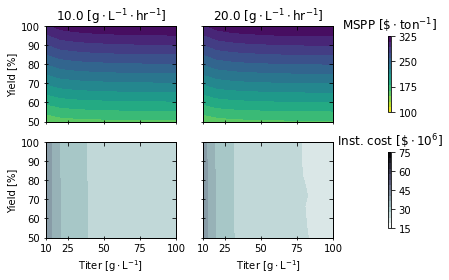

In [7]:
from biosteam.plots import plot_contour_2d, MetricBar
import matplotlib.pyplot as plt

xlabel = 'Titer [$\mathrm{g} \cdot \mathrm{L}^{-1}$]'
ylabel = "Yield [%]"
xticks = [10, 25, 50, 75, 100]
yticks = [50, 60, 70, 80, 90, 100]
million_dollar = r"\mathrm{\$} \cdot \mathrm{10}^{6}"
MSPP_units = r"$\mathrm{\$} \cdot \mathrm{ton}^{-1}$"
productivity_units = "$\mathrm{g} \cdot \mathrm{L}^{-1} \cdot \mathrm{hr}^{-1}$"
installed_cost_units = f"${million_dollar}$"
metric_bars = (MetricBar('MSPP', MSPP_units, plt.cm.get_cmap('viridis_r'),
                         [100, 175, 250, 325], 15, None),
               MetricBar("Inst. cost", installed_cost_units,
                         plt.cm.get_cmap('bone_r'),
                         [15, 30, 45, 60, 75], 15))

plot_contour_2d(titers, 100.*yields, productivities, data, 
                xlabel, ylabel, xticks, yticks, metric_bars, 
                Z_value_format=lambda Z: f"{Z:.1f} [{productivity_units}]",
                fillblack=False)
plt.tight_layout()

## Perform Monte Carlo analysis

Being able to set TRY specifications enables all sorts of analysis around reactor performance. Here we will use BioSTEAM's Monte Carlo tools to analyse how the minimum sugar price is impacted across a range of titers with uncertainty on the number of operating days while keeping constant the amount of ethanol produced in a year.

[0] Elapsed time: 2 sec
[1] Elapsed time: 2 sec
[2] Elapsed time: 3 sec
[3] Elapsed time: 3 sec
[4] Elapsed time: 4 sec
[5] Elapsed time: 4 sec
[6] Elapsed time: 5 sec
[7] Elapsed time: 5 sec
[8] Elapsed time: 6 sec
[9] Elapsed time: 6 sec


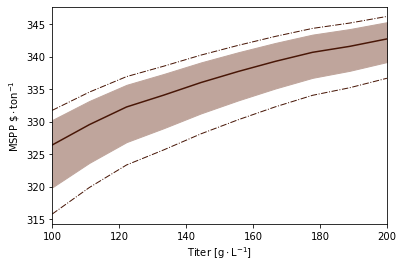

In [8]:
from chaospy import distributions as shape
MSPP_metric = bst.Metric('MSPP', get_sugar_price, 'USD / ton')
model = bst.Model(ethanol_production_sys, (MSPP_metric,))
 
@model.parameter(distribution=shape.Uniform(150, 250), units='day/yr')
def set_operating_days(operating_days):
    ethanol_production_tea.operating_days = operating_days
    spec.production = yearly_production / 24 / operating_days * 907.185

N_samples = 10
rule = 'L' # For Latin-Hypercube sampling
samples = model.sample(N_samples, rule)
model.load_samples(samples)
setter = spec.load_titer
titers = np.linspace(100, 200, 10)
metric_data_dct = model.evaluate_across_coordinate('Titer [g/L]', setter, titers)
MSPP_metric_data = metric_data_dct[MSPP_metric.index]
plt.figure()
bst.plots.plot_montecarlo_across_coordinate(titers, MSPP_metric_data)
plt.xlabel(xlabel)
plt.ylabel(f"MSPP {MSPP_units}")
plt.xlim([100, 200])
plt.show()